In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, cohen_kappa_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

In [2]:
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
REDUCED_SAMPLES_PER_CLASS = 2400
epochs = 20
learning_rate = 3.9e-5
num_classes = 5
folder_path = './../../datasets/dataset1'


# Function to load and preprocess images
def preprocess_image(img_path, img_height, img_width):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [img_height, img_width])
    img = img / 255.0  # Normalize to [0,1]
    return img

# Function to create TensorFlow dataset
def create_dataset(image_paths, labels, img_height, img_width, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x, img_height, img_width), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Improve performance
    return dataset

# Function to get image paths and labels with specific sampling for class 0 and 2
def get_image_paths_and_labels(directory, reduced_samples_per_class):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_folder = os.path.join(directory, class_name)
        if os.path.isdir(class_folder):
            class_images = [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]
            if class_name in ['0', '2']:  # Reduce images to 3000 for class 0 and 2
                class_images = np.random.choice(class_images, reduced_samples_per_class, replace=False)
            image_paths.extend(class_images)
            labels.extend([class_to_index[class_name]] * len(class_images))
    
    return image_paths, labels

# Load image paths and labels
image_paths, labels = get_image_paths_and_labels(folder_path, REDUCED_SAMPLES_PER_CLASS)

# Convert labels to NumPy array
labels = np.array(labels).reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
labels_onehot = encoder.fit_transform(labels)

# Create TensorFlow dataset
dataset = create_dataset(image_paths, labels_onehot, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)

# Split the dataset into train, validation, and test sets using scikit-learn
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels_onehot, test_size=0.4, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create TensorFlow datasets for training, validation, and testing
train_dataset = create_dataset(X_train, y_train, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)
val_dataset = create_dataset(X_val, y_val, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)
test_dataset = create_dataset(X_test, y_test, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE)

In [3]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

# Custom Kappa Metric
def kappa_score(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    kappa_score = tf.py_function(func=cohen_kappa_score, inp=[y_true, y_pred], Tout=tf.float32)
    return kappa_score

In [4]:

metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    kappa_score,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [5]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()
    
def show_confusion_matrix(model):
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(num_classes)], zero_division=0))

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(conf_matrix)

    # Plot the confusion matrix
    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, [str(i) for i in range(num_classes)])

    

In [6]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

train_accuracy->  [0.26936155557632446, 0.2935398519039154, 0.2916509211063385, 0.30166226625442505, 0.30487343668937683, 0.31242915987968445, 0.3139403164386749, 0.3188515305519104, 0.3203626871109009, 0.3237627446651459, 0.32319608330726624, 0.3243294358253479, 0.32659614086151123, 0.3275406062602997, 0.3279184103012085, 0.3275406062602997, 0.33037400245666504, 0.33075180649757385, 0.33282962441444397, 0.3337740898132324]
val_accuracy->  [0.2980169951915741, 0.3008498549461365, 0.3008498549461365, 0.3099150061607361, 0.3138810098171234, 0.3144475817680359, 0.3167138695716858, 0.31784701347351074, 0.31784701347351074, 0.3252124786376953, 0.32237958908081055, 0.32181301712989807, 0.3252124786376953, 0.3280453383922577, 0.3257790505886078, 0.3274787664413452, 0.32861191034317017, 0.32917848229408264, 0.33087819814682007, 0.33087819814682007]
train_loss->  [1.5619992017745972, 1.4911357164382935, 1.4877684116363525, 1.4847116470336914, 1.481870174407959, 1.479219913482666, 1.476770162582

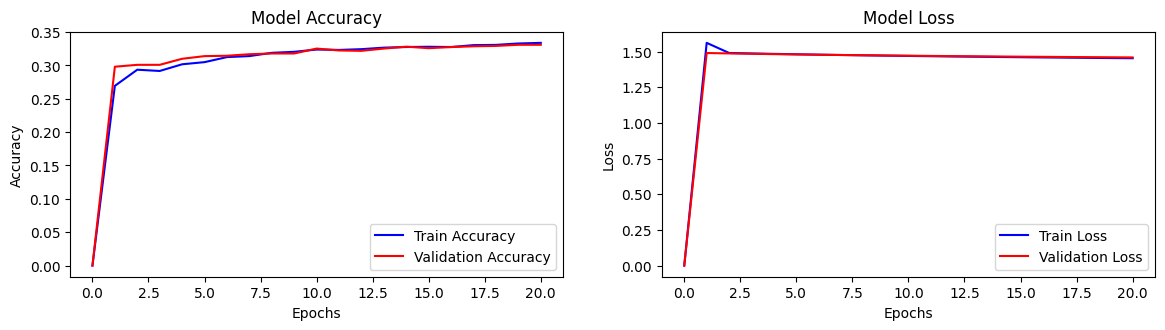

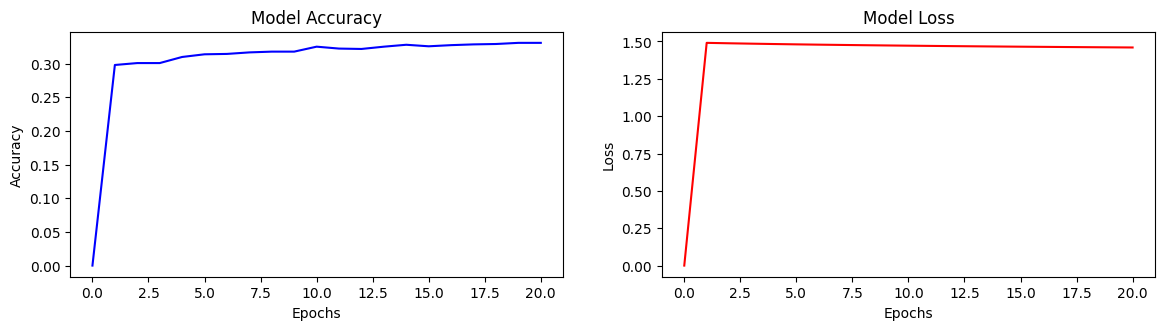

In [8]:
accuracyGraph(history)

56/56 [==============================] - 4s 75ms/step
              precision    recall  f1-score   support

           0       0.35      0.19      0.25       480
           1       0.37      0.39      0.38       489
           2       0.30      0.62      0.41       480
           3       0.00      0.00      0.00       174
           4       0.00      0.00      0.00       142

    accuracy                           0.33      1765
   macro avg       0.20      0.24      0.21      1765
weighted avg       0.28      0.33      0.28      1765

[[ 92 147 237   0   4]
 [ 92 191 206   0   0]
 [ 60 120 299   0   1]
 [ 17  39 118   0   0]
 [  2  19 121   0   0]]


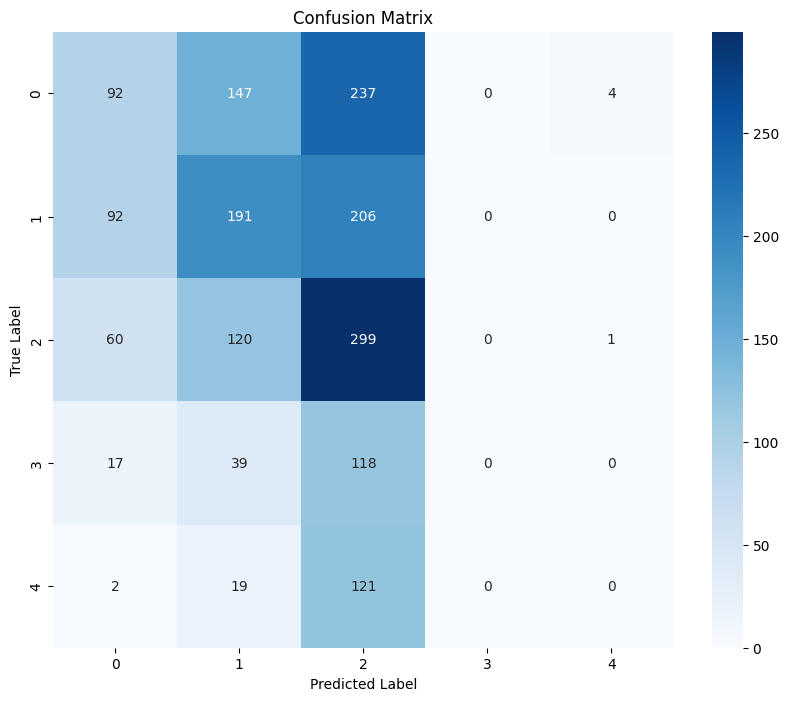

In [9]:
show_confusion_matrix(model)

In [10]:
_metrices = model.evaluate(test_dataset)
print("Test Metrices", _metrices)

56/56 [==============================] - 5s 81ms/step - loss: 1.4604 - accuracy: 0.3297 - auc: 0.6906 - balanced_accuracy: 0.2497 - fscore: 0.2039 - kappa_score: 0.0748 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Metrices [1.460379958152771, 0.3297450542449951, 0.6905637383460999, 0.2496758997440338, 0.20385995507240295, 0.07482976466417313, 0.0, 0.0]


In [11]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers[:15]:   
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True


# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)

# Continue training (fine-tuning)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Epoch 1/20


c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


166/166 [==============================] - 25s 139ms/step - loss: 1.4965 - accuracy: 0.2849 - auc: 0.6640 - balanced_accuracy: 0.2161 - fscore: 0.1739 - kappa_score: 0.0168 - precision: 0.5600 - recall: 0.0020 - val_loss: 1.4468 - val_accuracy: 0.3110 - val_auc: 0.6897 - val_balanced_accuracy: 0.2343 - val_fscore: 0.1478 - val_kappa_score: 0.0466 - val_precision: 0.2000 - val_recall: 5.6657e-04
Epoch 2/20
166/166 [==============================] - 23s 139ms/step - loss: 1.4362 - accuracy: 0.3224 - auc: 0.6951 - balanced_accuracy: 0.2657 - fscore: 0.2284 - kappa_score: 0.0760 - precision: 0.2761 - recall: 0.0070 - val_loss: 1.3975 - val_accuracy: 0.3394 - val_auc: 0.7151 - val_balanced_accuracy: 0.2865 - val_fscore: 0.2556 - val_kappa_score: 0.0962 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
166/166 [==============================] - 23s 139ms/step - loss: 1.3943 - accuracy: 0.3432 - auc: 0.7167 - balanced_accuracy: 0.3027 - fscore: 0.2662 - kappa_score: 0.1086 - pre

train_accuracy->  [0.2848507761955261, 0.322440505027771, 0.34321874380111694, 0.3588968515396118, 0.3808084726333618, 0.40838685631752014, 0.4289762079715729, 0.45051002502441406, 0.489610880613327, 0.524744987487793, 0.5358896851539612, 0.5697015523910522, 0.5959576964378357, 0.6061578989028931, 0.6037023067474365, 0.6860597133636475, 0.7368719577789307, 0.7561390399932861, 0.7410275936126709, 0.7663392424583435]
val_accuracy->  [0.31104815006256104, 0.3393767774105072, 0.3507082164287567, 0.3745042383670807, 0.37280452251434326, 0.3762039542198181, 0.37337109446525574, 0.3830028474330902, 0.37790367007255554, 0.37733709812164307, 0.3813031017780304, 0.36657223105430603, 0.355807363986969, 0.3535410761833191, 0.32181301712989807, 0.3626062273979187, 0.35184136033058167, 0.32181301712989807, 0.3099150061607361, 0.2957507073879242]
train_loss->  [1.4964711666107178, 1.4361979961395264, 1.3943040370941162, 1.3634605407714844, 1.3281276226043701, 1.2869313955307007, 1.2369184494018555, 1

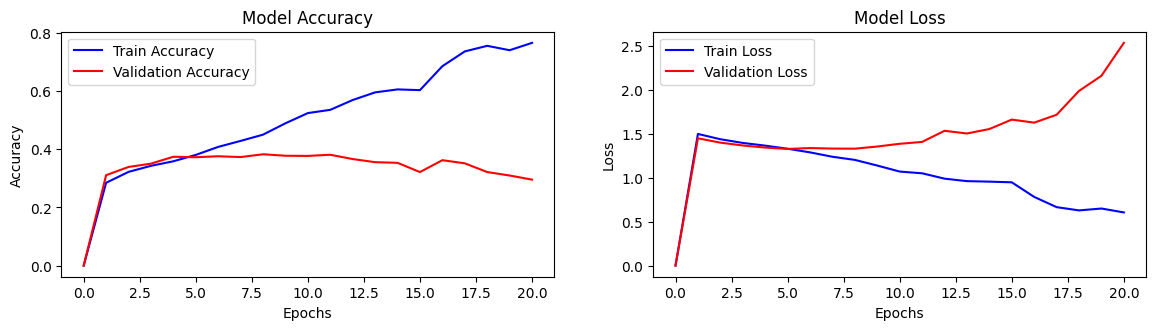

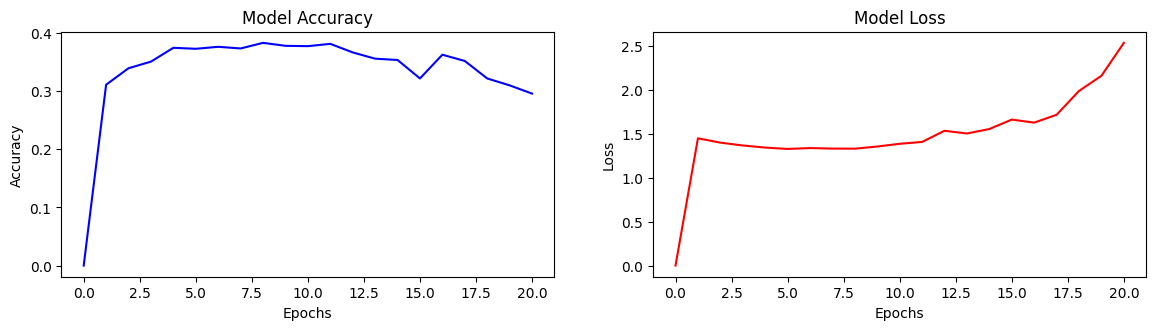

In [12]:
accuracyGraph(history)

56/56 [==============================] - 4s 74ms/step
              precision    recall  f1-score   support

           0       0.43      0.02      0.04       480
           1       0.39      0.11      0.18       489
           2       0.29      0.77      0.42       480
           3       0.24      0.36      0.29       174
           4       0.66      0.31      0.42       142

    accuracy                           0.31      1765
   macro avg       0.40      0.31      0.27      1765
weighted avg       0.38      0.31      0.24      1765

[[  9  60 372  34   5]
 [  9  56 366  54   4]
 [  2  26 368  75   9]
 [  0   3 103  63   5]
 [  1   0  61  36  44]]


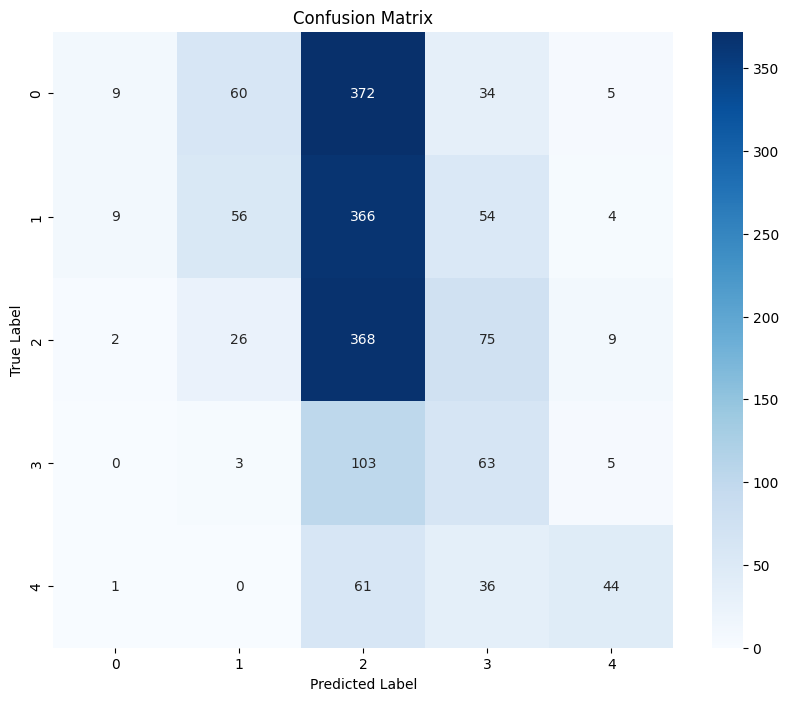

In [13]:
show_confusion_matrix(model)

In [14]:
_metrices = model.evaluate(test_dataset)
print("Test Metrices", _metrices)

56/56 [==============================] - 5s 80ms/step - loss: 2.5635 - accuracy: 0.3059 - auc: 0.6047 - balanced_accuracy: 0.3156 - fscore: 0.2449 - kappa_score: 0.0955 - precision: 0.3073 - recall: 0.2408
Test Metrices [2.5634920597076416, 0.30594900250434875, 0.6046893000602722, 0.31562525033950806, 0.24485203623771667, 0.09551390260457993, 0.30730295181274414, 0.24079319834709167]
